In [12]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ===============================
# 2. LOAD DATA
# ===============================

df = pd.read_csv("vietnam_housing_dataset.csv")

df.head()

,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Have certificate,NaN,8.60
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,7.50
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,Đông - Bắc,Đông - Bắc,5.0,NaN,NaN,Sale contract,NaN,8.90
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,NaN,3.5,Tây - Nam,Tây - Nam,2.0,2.0,3.0,Have certificate,Full,5.35
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,NaN,NaN,Đông - Nam,Đông - Nam,2.0,4.0,4.0,Have certificate,Full,6.90


In [3]:
# ===============================
# 3. CLEANING
# ===============================

# Drop only critical missing values
df = df.dropna(subset=['Price','Area'])

# Remove invalid area
df = df[df['Area'] > 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access Road        16932 non-null  float64
 4   House direction    8990 non-null   object 
 5   Balcony direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal status       25723 non-null  object 
 10  Furniture state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


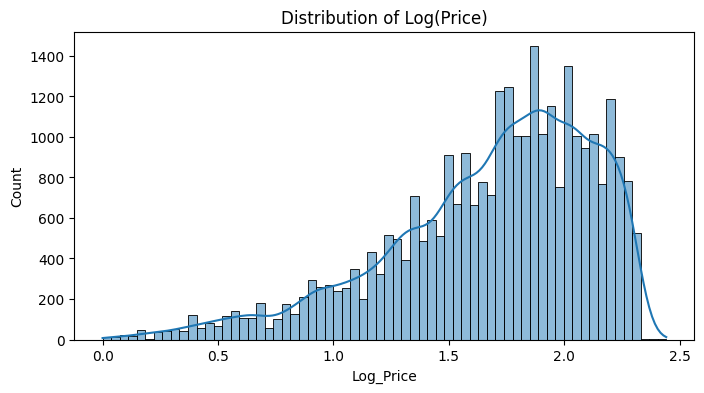

In [4]:
# ===============================
# 4. LOG TRANSFORM TARGET
# ===============================

df['Log_Price'] = np.log(df['Price'])

plt.figure(figsize=(8,4))
sns.histplot(df['Log_Price'], kde=True)
plt.title("Distribution of Log(Price)")
plt.show()

In [5]:
# ===============================
# 5. DEFINE X AND y
# ===============================

X = df.drop(columns=['Price','Log_Price'])
y = df['Log_Price']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

print("Total features after encoding:", X.shape[1])

Total features after encoding: 10286


In [6]:
# ===============================
# 6. TRAIN TEST SPLIT
# ===============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (24183, 10286)
Test size: (6046, 10286)


In [9]:
# ===============================
# 7. REMOVE MULTICOLLINEARITY
# ===============================

def drop_high_vif(X, threshold=10):
    X = X.copy()
    
    # Keep numeric only
    X = X.select_dtypes(include=[np.number])
    
    # Convert to float
    X = X.astype(float)
    
    # Replace inf values
    X = X.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with NaN ONLY for VIF calculation
    X = X.dropna()
    
    while True:
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) 
             for i in range(X.shape[1])],
            index=X.columns
        )
        
        max_vif = vif.max()
        
        if max_vif > threshold:
            drop_feature = vif.idxmax()
            print("Dropping:", drop_feature, "VIF:", round(max_vif,2))
            X = X.drop(columns=[drop_feature])
        else:
            break
            
    return X

# Apply
X_train_clean = drop_high_vif(X_train, threshold=10)

# Keep only selected columns
X_train = X_train[X_train_clean.columns]
X_test = X_test[X_train.columns]

print("Remaining features:", X_train.shape[1])

Dropping: Bathrooms VIF: 21.06
Dropping: Bedrooms VIF: 11.92
Remaining features: 4


In [13]:
# ===============================
# 8. IMPUTATION + SCALING
# ===============================

# Impute numeric features bằng median (an toàn với housing)
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [43]:
# ===============================
# 9. RIDGE WITH CROSS VALIDATION
# ===============================

from sklearn.linear_model import RidgeCV
import numpy as np

alphas = np.logspace(-3, 3, 50)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print("Best alpha:", ridge_cv.alpha_)

y_pred_ridge = ridge_cv.predict(X_test_scaled)

Best alpha: 19.306977288832496


In [44]:
# ===============================
# 9. LINEAR REGRESSION
# ===============================

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_lin = lin_reg.predict(X_test_scaled)

In [45]:
# ===============================
# 10. RIDGE
# ===============================

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

In [46]:
# ===============================
# 11. LASSO
# ===============================

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)

In [47]:
# ===============================
# 12. RANDOM FOREST
# ===============================

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [48]:
# ===============================
# 13. EVALUATION
# ===============================

def evaluate(model_name, y_true, y_pred):
    print(f"\n{model_name}")
    print("R2:", round(r2_score(y_true, y_pred), 4))
    print("MAE:", round(mean_absolute_error(y_true, y_pred), 4))

evaluate("Linear Regression", y_test, y_pred_lin)
evaluate("Ridge", y_test, y_pred_ridge)
evaluate("Lasso", y_test, y_pred_lasso)
evaluate("Random Forest", y_test, y_pred_rf)


Linear Regression
R2: 0.1471
MAE: 0.3229

Ridge
R2: 0.1471
MAE: 0.3229

Lasso
R2: 0.1453
MAE: 0.324

Random Forest
R2: 0.2131
MAE: 0.2934


In [49]:
# ===============================
# 14. CROSS VALIDATION
# ===============================

cv_scores = cross_val_score(
    ridge,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='r2'
)

print("Ridge CV mean R2:", round(cv_scores.mean(), 4))
print("Ridge CV std:", round(cv_scores.std(), 4))

Ridge CV mean R2: 0.1503
Ridge CV std: 0.0051


In [50]:
# ===============================
# 15. LINEAR FEATURE IMPORTANCE
# ===============================

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Ridge_Coefficient": ridge.coef_
})

coef_df = coef_df.reindex(
    coef_df['Ridge_Coefficient'].abs().sort_values(ascending=False).index
)

coef_df.head(10)

,Feature,Ridge_Coefficient
3,Floors,0.175917
0,Area,0.075890
2,Access Road,0.041328
1,Frontage,-0.002142


In [51]:
# ===============================
# 16. RF FEATURE IMPORTANCE
# ===============================

rf_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
})

rf_importance = rf_importance.sort_values(
    by="Importance",
    ascending=False
)

rf_importance.head(10)

,Feature,Importance
0,Area,0.444128
3,Floors,0.200739
2,Access Road,0.179351
1,Frontage,0.175782


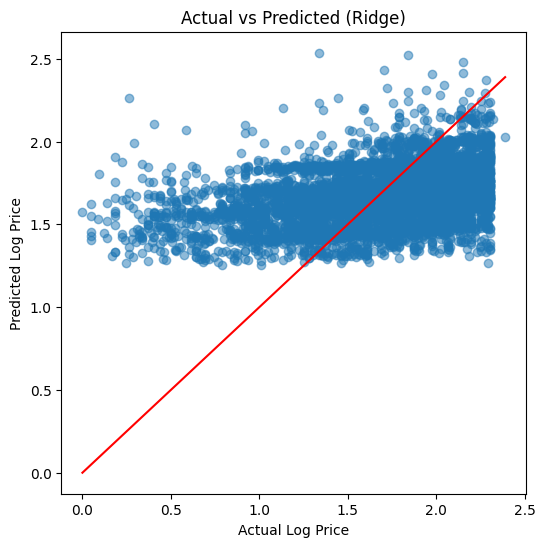

In [52]:
# ===============================
# ACTUAL vs PREDICTED
# ===============================

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Actual vs Predicted (Ridge)")
plt.show()

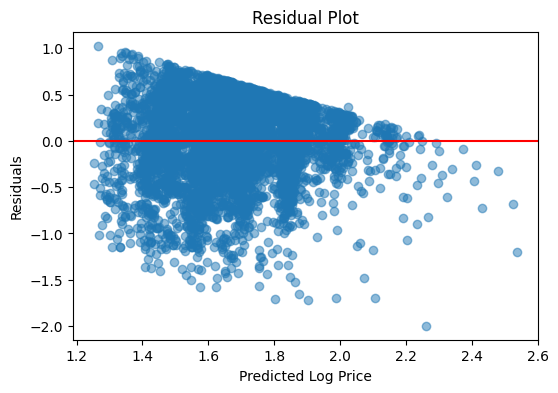

In [53]:
# ===============================
# RESIDUAL PLOT
# ===============================

residuals = y_test - y_pred_ridge

plt.figure(figsize=(6,4))
plt.scatter(y_pred_ridge, residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

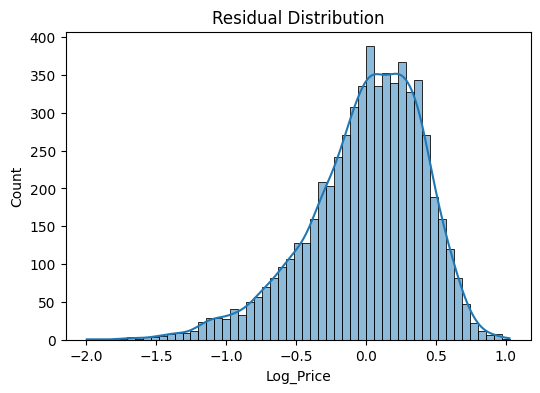

In [54]:
# ===============================
# RESIDUAL DISTRIBUTION
# ===============================

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

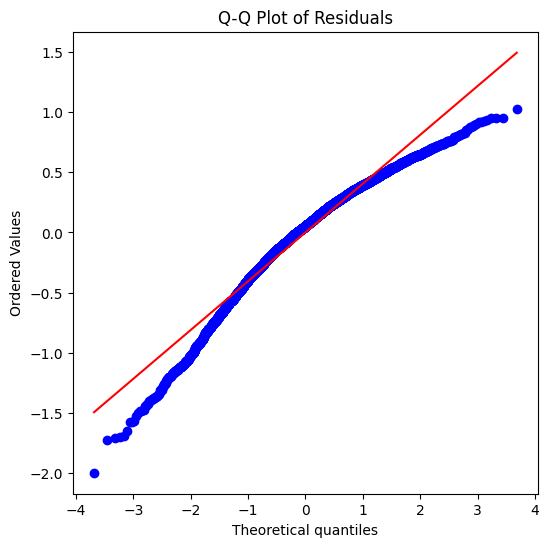

In [55]:
# ===============================
# QQ PLOT
# ===============================

import scipy.stats as stats

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

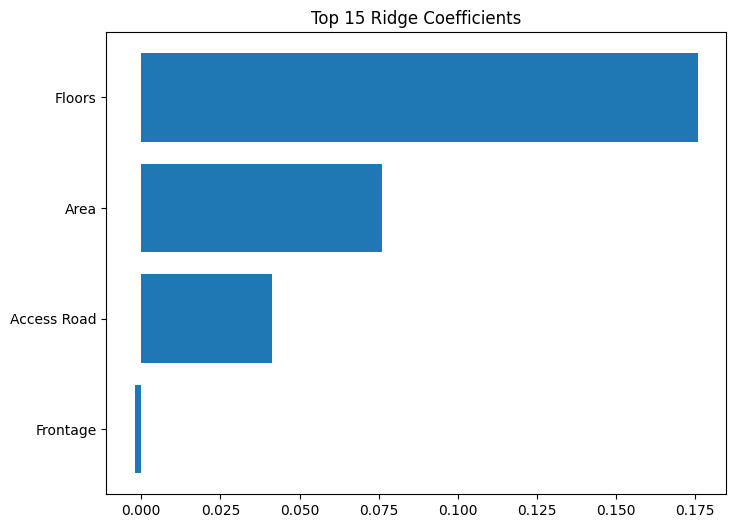

In [56]:
# ===============================
# RIDGE FEATURE IMPORTANCE PLOT
# ===============================

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": ridge.coef_
})

coef_df = coef_df.reindex(
    coef_df['Coefficient'].abs().sort_values(ascending=False).index
)

top_features = coef_df.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features["Feature"], top_features["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 15 Ridge Coefficients")
plt.show()

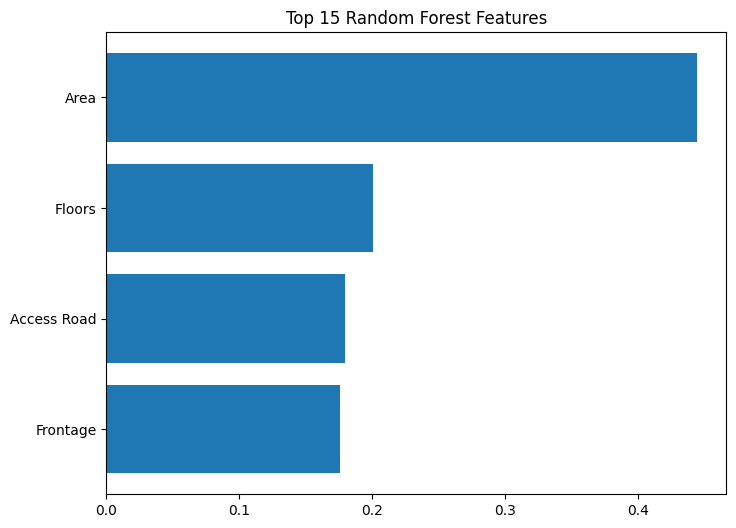

In [27]:
# ===============================
# RANDOM FOREST FEATURE IMPORTANCE
# ===============================

rf_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
})

rf_importance = rf_importance.sort_values(
    by="Importance",
    ascending=False
).head(15)

plt.figure(figsize=(8,6))
plt.barh(rf_importance["Feature"], rf_importance["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Random Forest Features")
plt.show()

In [28]:
print("Train R2:", ridge.score(X_train_scaled, y_train))
print("Test R2:", ridge.score(X_test_scaled, y_test))

Train R2: 0.15068940017813692
Test R2: 0.14714138887651196
